In [1]:
# Exploring the adult data set from the UCI repository.
# Download the files adult.data and adult.test
# from https://archive.ics.uci.edu/ml/machine-learning-databases/adult/
import matplotlib.pyplot as plt

In [2]:
from __future__ import print_function
import pandas as pd
import ipywidgets as widgets
import numpy as np
import adult
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from forest_clusters import ForestClusters, buckets, total_variation

original = adult.original
categorical = [col for col in original.columns 
               if ~np.issubdtype(original[col], np.number)]
original[categorical] = original[categorical].fillna(value = 'None')

In [3]:
X = pd.get_dummies(original[original.columns.difference(['Target'])])

def encode_features(original):
    return X.loc[original.index]

y = adult.labels

original_train, original_test, X_train, X_test, y_train, y_test = train_test_split(original, X, y, train_size=0.7)

forest = RandomForestClassifier(n_estimators = 10, max_depth = 10)
forest = forest.fit(X_train, y_train)
print("Score %f" % forest.score(X_test, y_test))

leaf_encoder = OneHotEncoder()
leaf_encoder = leaf_encoder.fit(forest.apply(X))

/home/arthur/env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Score 0.849519


In [4]:
n_clusters = 30
c = ForestClusters(forest, leaf_encoder, n_clusters = n_clusters)
c.fit(X_train.sample(n = 1000))

In [118]:
from itertools import permutations

def cluster_distance(c1, c2):
    n_clusters = c1.kmeans.n_clusters
    points = X.sample(n = 100)
    def permutation_distance(pi):
        p1 = c1.predict(points)
        p2 = np.vectorize(lambda k: pi[k])(c2.predict(points))
        return (p1 != p2).mean()
    return min(permutation_distance(pi)
               for pi in permutations(range(n_clusters)))

import operator

def greedy_cluster_distance(c1, c2):
    n_clusters = c1.kmeans.n_clusters
    n_points = 100
    points = X.sample(n = n_points)
    weights = {(i, j): sum(np.logical_and(c1.predict(points) == i, 
                                          c2.predict(points) == j))
               for i in range(n_clusters) for j in range(n_clusters)}
    total_weight = n_points
    while len(weights) != 0:
        ((i, j), weight) = max(weights.items(), key=operator.itemgetter(1))
        total_weight = total_weight - weight
        weights = {(ii, jj): v for (ii, jj), v in weights.items() if ii != i and jj != j}
    return total_weight / n_points

def instability(n, samples):
    def it():
        c1 = ForestClusters(forest, leaf_encoder, n_clusters = n)
        c1.fit(X_train.sample(n = 100))
        c2 = ForestClusters(forest, leaf_encoder, n_clusters = n)
        c2.fit(X_train.sample(n = 100))
        return cluster_distance(c1, c2)
    return np.array([it() for k in range(samples)]).mean()

def greedy_instability(n, samples):
    def it():
        c1 = ForestClusters(forest, leaf_encoder, n_clusters = n)
        c1.fit(X_train.sample(n = 100))
        c2 = ForestClusters(forest, leaf_encoder, n_clusters = n)
        c2.fit(X_train.sample(n = 100))
        return greedy_cluster_distance(c1, c2)
    return np.array([it() for k in range(samples)]).mean()

In [130]:
for i in range(20, 21):
    print("%d | %0.3f" % (i, greedy_instability(i, 15)))

20 | 0.440


In [87]:
instability(6, 15)

0.28800000000000003

In [89]:
instability(8, 15)

0.38466666666666666

In [18]:
from display_cluster import display_cluster
display_cluster(c, original, original_test, y_test,
                encode_features=encode_features)

,Size,Accuracy,Mean Votes
0,10953,0.800055,8.457683
1,410,1.000000,0.039024
2,362,0.997238,29.198895
3,134,1.000000,0.149254
4,98,0.989796,0.377551
5,152,1.000000,0.401316
6,31,1.000000,0.709677
7,113,0.991150,0.168142
8,407,0.990172,0.152334
9,81,1.000000,0.234568


interactive(children=(BoundedIntText(value=0, description='Cluster', max=30), Dropdown(description='Column', o…

10     0.216952
71     0.091927
332    0.082304
31     0.059374
436    0.047158
70     0.045178
333    0.031666
64     0.027435
38     0.027230
155    0.027093
156    0.021088
13     0.018631
294    0.017812
345    0.015833
147    0.014809
77     0.012284
136    0.012079
133    0.011943
483    0.011738
105    0.010237
108    0.009145
218    0.008189
201    0.007439
129    0.007371
137    0.007371
152    0.007098
225    0.006483
287    0.005664
379    0.005323
477    0.005323
         ...   
113    0.000068
278    0.000068
276    0.000068
316    0.000068
356    0.000068
427    0.000068
403    0.000068
395    0.000068
428    0.000068
347    0.000068
307    0.000068
267    0.000068
21     0.000068
53     0.000068
187    0.000068
109    0.000068
506    0.000068
490    0.000068
450    0.000068
258    0.000068
261    0.000068
365    0.000068
373    0.000068
485    0.000068
228    0.000068
14     0.000068
62     0.000068
166    0.000068
262    0.000068
501    0.000068
Length: 193, dtype: floa

71     0.695833
155    0.129167
156    0.062500
152    0.041667
136    0.033333
137    0.012500
96     0.008333
73     0.004167
70     0.004167
64     0.004167
61     0.004167
dtype: float64

10     0.825822
133    0.048721
129    0.046285
13     0.036541
147    0.020706
39     0.020706
42     0.001218
dtype: float64

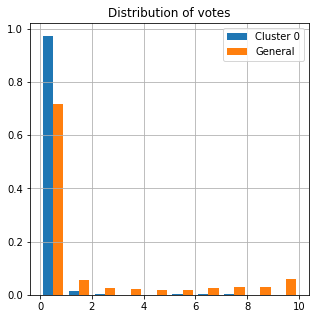

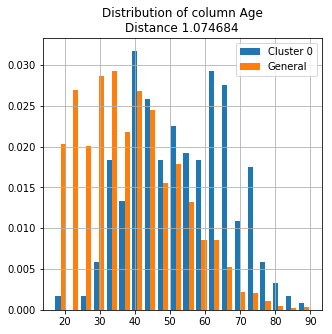

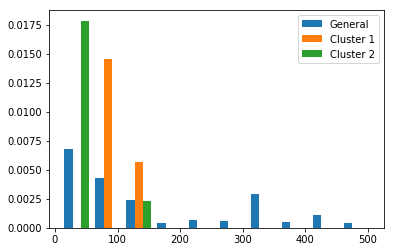

In [6]:
def compare_paths(tree, clusters):
    fig, ax = plt.subplots()
    test_leaves = forest.apply(X_test)
    test_clusters = c.kmeans.predict(leaf_encoder.transform(test_leaves))
    leaves_general = test_leaves[:,tree]
    leaves_clusters = [test_leaves[test_clusters == c, tree] for c in clusters]
    ax.hist([leaves_general] + leaves_clusters, density = True,
             label = ['General'] + ['Cluster %d' % c for c in clusters])
    ax.legend()
    display(pd.Series(leaves_general).value_counts(normalize = True))
    for leaves in leaves_clusters:
        display(pd.Series(leaves).value_counts(normalize = True))
        
compare_paths(2, [1, 2])

In [7]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(forest.estimators_[1], 
                           feature_names = X_test.columns,
                           out_file = None, filled = True, rounded = True, node_ids = True)
graph = graphviz.Source(dot_data)
# graph

In [8]:
def build_path(tree, feature_names, node):
    path = []
    first_node = node
    direction = None
    while node != 0:
        path = [(node, direction)] + path
        right_idx = np.where(tree.children_right == node)[0]
        left_idx  = np.where(tree.children_left  == node)[0]
        if len(right_idx) != 0:
            node = right_idx[0]
            direction = 'right'
        else: # The node must be a left child
            node = left_idx[0]
            direction = 'left'
    path = [(0, direction)] + path
    for node in path:
        if node[0] != first_node:
            node_info = (feature_names[tree.feature[node[0]]], tree.threshold[node[0]])
            if node[1] == 'left':
                print("%s < %0.3f" % node_info)
            else:
                print("%s >= %0.3f" % node_info)

In [9]:
def influential_path(tree, rank, cluster):
    test_leaves = forest.apply(X_test)
    test_clusters = c.kmeans.predict(leaf_encoder.transform(test_leaves))
    leaves_cluster = pd.Series(test_leaves[test_clusters == cluster, tree]).value_counts(normalize = True)
    node = leaves_cluster.index[rank]
    proportion = leaves_cluster.iloc[rank]
    print("Path %d, proportion %.03f" % (node, proportion))
    build_path(forest.estimators_[tree].tree_, X_test.columns, node)

influential_path(7, 0, 6)

Path 32, proportion 0.939
Occupation_Priv-house-serv < 0.500
Sex_Female < 0.500
Martial Status_Never-married < 0.500
Education-Num < 12.500
Occupation_Handlers-cleaners < 0.500
Martial Status_Divorced < 0.500
Relationship_Husband >= 0.500
Education-Num >= 8.500
Race_Amer-Indian-Eskimo < 0.500
Country_Mexico < 0.500


In [10]:
test_leaves = forest.apply(X_test)
test_clusters = c.kmeans.predict(leaf_encoder.transform(test_leaves))
(sum(test_leaves[:,6] == 52), sum(test_clusters == 6))
(sum(test_leaves[:,7] == 345), sum(test_clusters == 6))

(0, 557)